In [1]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "careamics[examples]>=0.0.15",
# ]
# ///


The SEM dataset is composed of a training and a validation images acquired on a scanning 
electron microscopy (SEM). They were originally used in Buchholtz et al (2019) to showcase
CARE denoising. Here, we demonstrate the performances of Noise2Noise on this particular dataset!

In [2]:
# Imports necessary to execute the code
from pathlib import Path

import torch
import matplotlib.pyplot as plt
import tifffil
import numpy as np
from PIL import Image

from careamics import CAREamist
from careamics.config import create_n2n_configuration
from careamics.utils.metrics import scale_invariant_psnr
from careamics_portfolio import PortfolioManager

In [3]:
use_gpu  = "yes" if len([torch.cuda.get_device_properties(i) for i in range(torch.cuda.device_count())]) > 0 else "no"
print(f"Using GPU: {use_gpu}")

Using GPU: yes


## Import the dataset

The dataset can be directly downloaded using the `careamics-portfolio` package, which
uses `pooch` to download the data.

The N2N SEM dataset consists of EM images with 7 different levels of noise:

- Image 0 is recorded with 0.2 us scan time
- Image 1 is recorded with 0.5 us scan time
- Image 2 is recorded with 1 us scan time
- Image 3 is recorded with 1 us scan time
- Image 4 is recorded with 2.1 us scan time
- Image 5 is recorded with 5.0 us scan time
- Image 6 is recorded with 5.0 us scan time and is the avg. of 4 images


In [4]:
# instantiate data portfolio manage
portfolio = PortfolioManager()

# and download the data
root_path = Path("./data")
download = portfolio.denoising.N2N_SEM.download(root_path)
files = [f for f in download if f.endswith("tif")]
files.sort()

100%|████████████████████████████████████████| 173M/173M [00:00<00:00, 362GB/s]
Unzipping contents of '/localscratch/careamics-examples/applications/n2n/2D/data/denoising-N2N_SEM' to '/localscratch/careamics-examples/applications/n2n/2D/data/denoising-N2N_SEM.unzip'


## Visualize data

Text(0.5, 1.0, 'Target crop (1 us)')

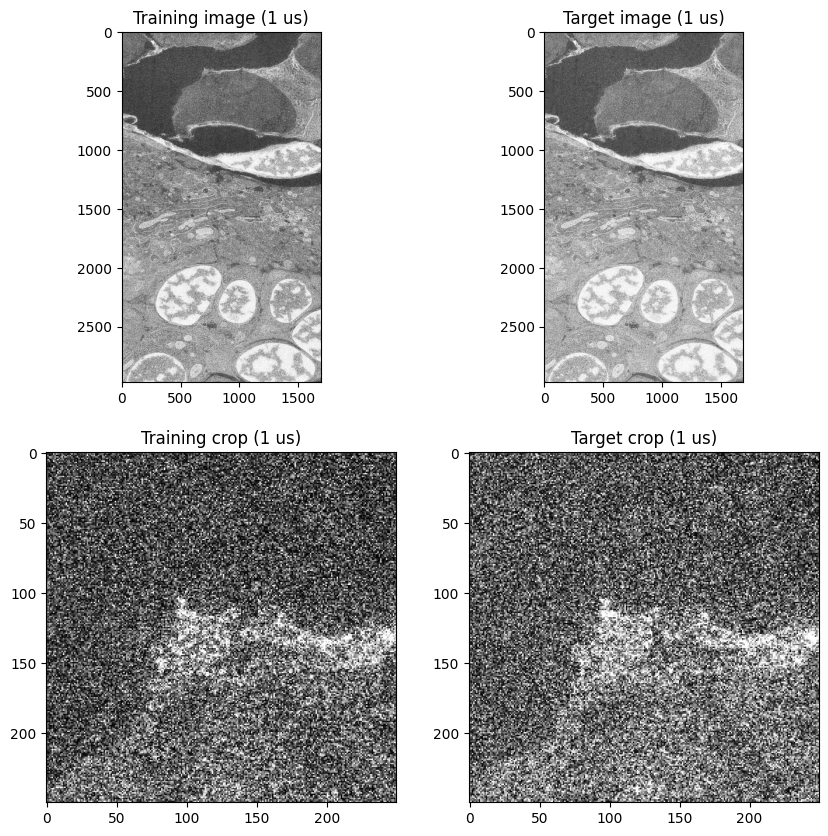

In [5]:
# load training and target image and show them side by side
train_stack = tifffile.imread(files[1])

# use the 1 us scan time to perform Noise2Noise
train_image = train_stack[2]
train_target = train_stack[3]

# plot the two images and a crop
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(train_image, cmap="gray")
ax[0, 0].set_title("Training image (1 us)")

ax[0, 1].imshow(train_target, cmap="gray")
ax[0, 1].set_title("Target image (1 us)")

x_start, x_end = 600, 850
y_start, y_end = 200, 450
ax[1, 0].imshow(train_image[y_start:y_end, x_start:x_end], cmap="gray")
ax[1, 0].set_title("Training crop (1 us)")

ax[1, 1].imshow(train_target[y_start:y_end, x_start:x_end], cmap="gray")
ax[1, 1].set_title("Target crop (1 us)")

## Train with CAREamics

The easiest way to use CAREamics is to create a configuration and a `CAREamist`. 

### Create configuration

The configuration can be built from scratch, giving the user full control over the various
parameters available in CAREamics. However, a straightforward way to create a configuration
for a particular algorithm is to use one of the convenience functions.

In [6]:
config = create_n2n_configuration(
    experiment_name="sem_n2n",
    data_type="array",
    axes="YX",
    patch_size=(64, 64),
    batch_size=64,
    num_epochs=50,
)

print(config)

{'algorithm_config': {'algorithm': 'n2n',
                      'loss': 'mae',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1,
                                'use_batch_norm': True},
                      'optimizer': {'name': 'Adam', 'parameters': {}}},
 'data_config': {'axes': 'YX',
                 'batch_size': 64,
                 'data_type': 'array',
                 'patch_size': [64, 64],
                 'train_dataloader_params': {'

### Train

A `CAREamist` can be created using a configuration alone, and then be trained by using
the data already loaded in memory.

In [7]:
# instantiate a CAREamist
careamist = CAREamist(source=config)

# train
careamist.train(
    train_source=train_image,
    train_target=train_target,
    val_minimum_split=5,
)

No working directory provided. Using current working directory: /localscratch/careamics-examples/applications/n2n/2D.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Extracted 1269 patches from input array.
Computed dataset mean: [37102.15], std: [19112.258]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 333 K  | train
---------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.335     Total estimated model params size (M

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/joran.deschamps/.cache/uv/environments-v2/juv-tmp-img6kpyq-1e74cfa049aa39f6/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Plot the losses.

{'epoch': [], 'learning_rate': [], 'step': [], 'train_loss_epoch': [], 'train_loss_step': [], 'val_loss': []}


Text(0.5, 1.0, 'Losses')

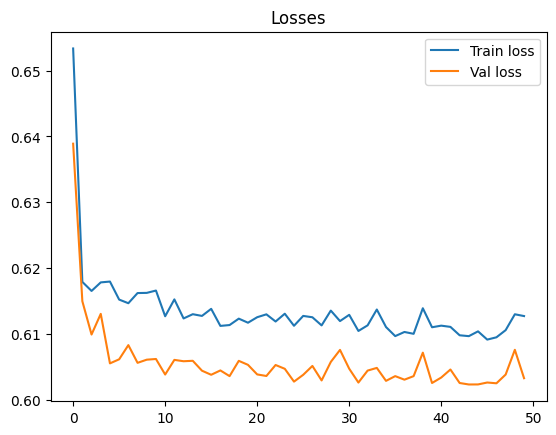

In [8]:
loss_dict = careamist.get_losses()
plt.plot(loss_dict["train_epoch"], loss_dict["train_loss"], loss_dict["val_epoch"], loss_dict["val_loss"])
plt.legend(["Train loss", "Val loss"])
plt.title("Losses")

## Predict with CAREamics

Prediction is done with the same `CAREamist` used for training. Because the image is large
we predict using tiling.

In [9]:
prediction = careamist.predict(source=train_image, tile_size=(256, 256))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/joran.deschamps/.cache/uv/environments-v2/juv-tmp-img6kpyq-1e74cfa049aa39f6/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

### Visualize the prediction

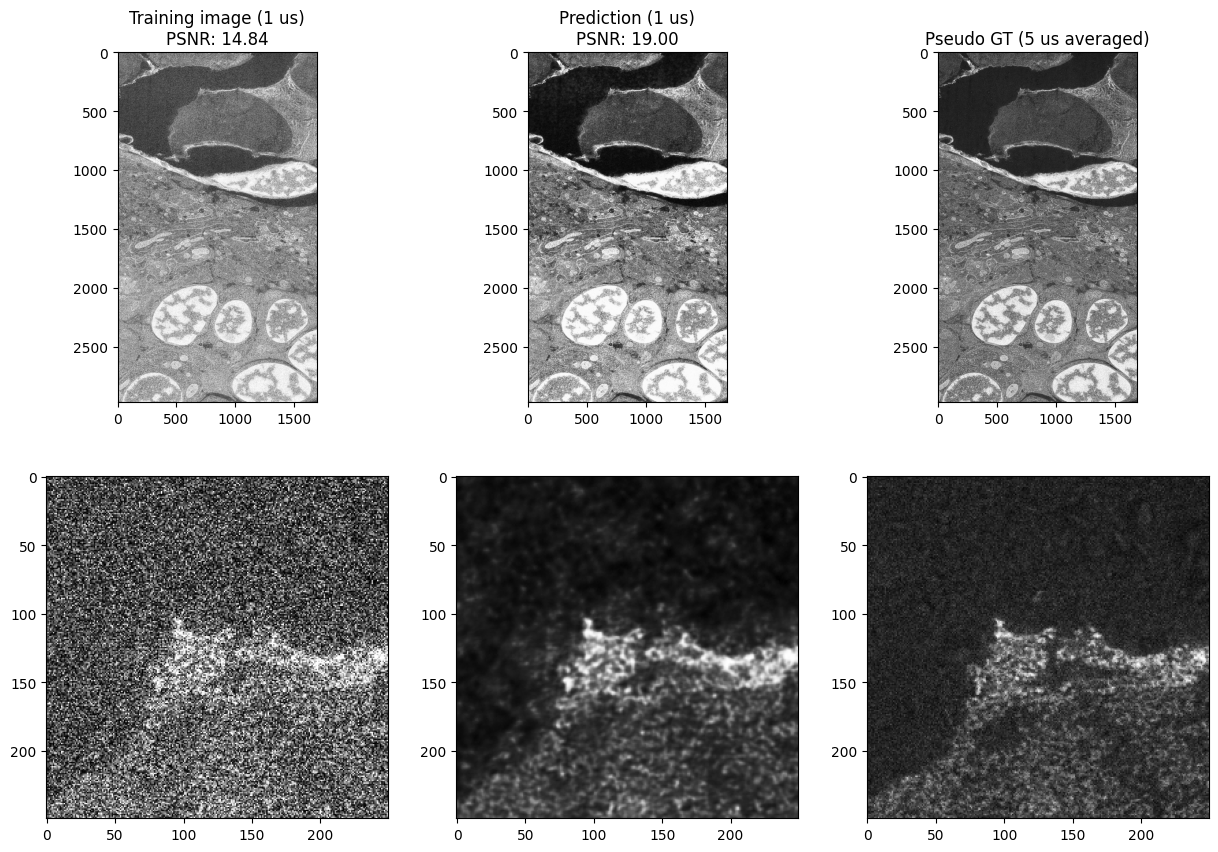

In [10]:
# get pseudo ground-truth from the 5 us averaged scan time
pseudo_gt = train_stack[-1]
psnr_noisy = scale_invariant_psnr(pseudo_gt, train_image)
psnr_pred = scale_invariant_psnr(pseudo_gt, prediction[0].squeeze())

# Show the full image and crops
x_start, x_end = 600, 850
y_start, y_end = 200, 450

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(train_image, cmap="gray")
ax[0, 0].title.set_text(f"Training image (1 us)\nPSNR: {psnr_noisy:.2f}")

ax[0, 1].imshow(prediction[0].squeeze(), cmap="gray")
ax[0, 1].title.set_text(f"Prediction (1 us)\nPSNR: {psnr_pred:.2f}")

ax[0, 2].imshow(pseudo_gt, cmap="gray")
ax[0, 2].title.set_text("Pseudo GT (5 us averaged)")

ax[1, 0].imshow(train_image[y_start:y_end, x_start:x_end], cmap="gray")
ax[1, 1].imshow(prediction[0].squeeze()[y_start:y_end, x_start:x_end], cmap="gray")
ax[1, 2].imshow(pseudo_gt[y_start:y_end, x_start:x_end], cmap="gray")

## Create cover

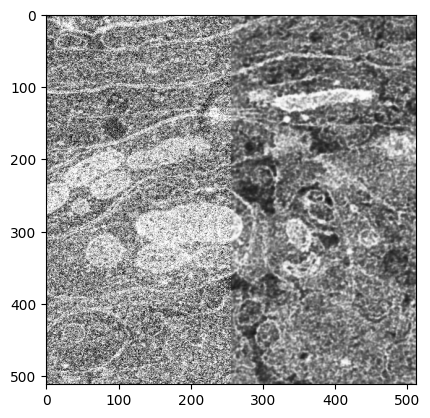

In [11]:
# create a cover image
x_start, width = 500, 512
y_start, height = 1400, 512

# create image
cover = np.zeros((height, width))   

# normalize train and prediction
norm_train = (train_image - train_image.min()) / (train_image.max() - train_image.min())

pred = prediction[0].squeeze()
norm_pred = (pred - pred.min()) / (pred.max() - pred.min())

# fill in halves
cover[:, :width // 2] = norm_train[y_start:y_start + height, x_start:x_start + width // 2]
cover[:, width // 2:] = norm_pred[y_start:y_start + height, x_start + width // 2:x_start + width]

# plot the single image
plt.imshow(cover, cmap="gray")

# save the image
im = Image.fromarray(cover * 255)
im = im.convert('L')
im.save("SEM_Noise2Noise.jpeg")